<a href="https://colab.research.google.com/github/seank1m/artificial-intelligence-for-robotics/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

In this assignment, you will be first introduced to a 3D point cloud dataset where you are required to (the marking criteria is provided in brackets):

1. Cluster the point cloud into k clusters. (30%)
2. Perform PCA on each cluster. (30%)
3. Perform SVM (on the training set) to learn cluster labels. (20%)
4. Apply the SVM classifier to the test set, to classify the new points and evaluate performance metrics. (20%)

# Data

Below we load a 3D point cloud dataset where each point is described using 7 features: its 3D position, RGB colour, and colour intensity. Additionally, each data point has a label. Due to the size of the dataset, it is hard to work with and visualize all points at once. Thus, for the assignment, only a proportion of the dataset is selected. You are not expected to understand the data loading process but to use the loaded data.

## Download Data
Dataset available from <http://semantic3d.net/view_dbase.php?chl=1>.

In [1]:
data_file = 'domfountain_station2_xyz_intensity_rgb'
label_file = 'sem8_labels_training'

In [2]:
!test ! -f {data_file}.txt \
  && wget http://semantic3d.net/data/point-clouds/training1/{data_file}.7z \
  && 7z e {data_file}.7z {data_file}.txt \
  && rm {data_file}.7z

!test ! -f {data_file}.labels \
  && wget http://semantic3d.net/data/{label_file}.7z \
  && 7z e {label_file}.7z  {data_file}.labels \
  && rm {label_file}.7z


--2025-03-12 10:07:46--  http://semantic3d.net/data/point-clouds/training1/domfountain_station2_xyz_intensity_rgb.7z
Resolving semantic3d.net (semantic3d.net)... 129.132.89.156
Connecting to semantic3d.net (semantic3d.net)|129.132.89.156|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271970652 (259M) [application/x-7z-compressed]
Saving to: ‘domfountain_station2_xyz_intensity_rgb.7z’

domfountain_station 100%[===================>] 259.37M  24.7MB/s    in 11s     

2025-03-12 10:07:58 (22.8 MB/s) - ‘domfountain_station2_xyz_intensity_rgb.7z’ saved [271970652/271970652]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 271970652 bytes (260 MiB)

Extracting archive: domfountain_station2_xyz_intensity_rgb.7z
--
Path = domfountain_station2_xyz

## Import Data

In [3]:
import math
import numpy as np
import pandas as pd

fields = dict(
    x='float64', y='float64', z='float64',
    intensity='int32',
    r='uint8', g='uint8', b='uint8',
)
df = pd.read_csv(
    data_file+'.txt',
    sep=' ',
    names=fields.keys(),
    dtype=fields,
)
df['label'] = pd.read_csv(
    data_file+'.labels',
    # sep=' ',  # only one column, and possibly not ended properly
    names=['label'],
    dtype='uint8',
)
df['label'] = df['label'].astype('category').cat.rename_categories({
    0: "unlabeled points",
    1: "man-made terrain",
    2: "natural terrain",
    3: "high vegetation",
    4: "low vegetation",
    5: "buildings",
    6: "hard scape",
    7: "scanning artefacts",
    8: "cars",
})
print(f"total points: {len(df):>16}")
print(df['label'].value_counts())
keep = df['label'].map(
    lambda x: x in {
      # "unlabeled points",
      "man-made terrain",
      "natural terrain",
      # "high vegetation",
      # "low vegetation",
      "buildings",
      # "hard scape",
      # "scanning artefacts",
      # "cars",
    }
)
df = df[keep].reset_index(drop=True)
df = df[::100].reset_index(drop=True)  # reduce dataset size
df

total points:         41268288
label
unlabeled points      32001613
buildings              5370835
man-made terrain       3192466
hard scape              540975
scanning artefacts      142402
low vegetation            9122
high vegetation           7925
cars                      2950
Name: count, dtype: int64


,x,y,z,intensity,r,g,b,label
0,-24.037,-88.014,-0.514,-1150,45,44,50,buildings
1,-18.345,-89.607,-2.110,-1322,33,37,40,buildings
2,-15.104,-95.208,-0.870,-1232,255,255,255,buildings
3,-6.484,-60.773,-0.188,-1124,30,29,34,buildings
4,-9.646,-49.016,-1.981,-1286,177,162,165,man-made terrain
...,...,...,...,...,...,...,...,...
85629,7.057,0.188,7.036,-461,62,66,75,buildings
85630,7.310,0.067,7.054,-699,86,93,101,buildings
85631,7.285,0.078,7.187,-707,80,89,98,buildings
85632,7.304,0.070,7.266,-691,86,90,101,buildings


## Preprocess Data

In [4]:
## Downsample using Open3D
%pip install -q open3d
import open3d as o3d

points = df[['x','y','z']].to_numpy()
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
# pcd = pcd.remove_duplicated_points()
pcd = pcd.remove_non_finite_points()
pcd = pcd.remove_statistical_outlier(10, 1)[0]
pcd = pcd.farthest_point_down_sample(10_000)
ds_points = np.array(pcd.points)
# ds_index = ((ds_points[:, None] == points).all(axis=-1) * (1 + np.arange(len(points)))).sum(axis=-1) - 1
ds_mask = (ds_points[:, None] == points).all(axis=-1).any(axis=0)
df = df[ds_mask].reset_index(drop=True)
df

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.0 MB/s eta 0:00:00


,x,y,z,intensity,r,g,b,label
0,-4.093,-15.353,-1.686,-1196,179,193,204,man-made terrain
1,-3.341,-15.605,-1.709,-1065,168,169,171,man-made terrain
2,-3.337,-15.026,-1.699,-1206,169,172,179,man-made terrain
3,-3.876,-14.706,-1.688,-1096,174,181,187,man-made terrain
4,-3.770,-13.819,-1.667,-1099,180,185,191,man-made terrain
...,...,...,...,...,...,...,...,...
9995,7.218,0.099,6.796,-756,41,47,61,buildings
9996,7.454,0.016,6.864,-691,92,101,110,buildings
9997,7.057,0.188,7.036,-461,62,66,75,buildings
9998,7.285,0.078,7.187,-707,80,89,98,buildings


In [5]:
## Split into Train and Test sets
test_mask = df['x'] < -5
df_full = df
df_test = df_full[test_mask].reset_index(drop=True)
df = df_full[~test_mask].reset_index(drop=True)  # training data

# Plotting
We define a helper function `plot_cloud(...)` that will make it easier to visualize our problem.
It is not necessary to know how this function works, only how to use it.

## Definitions

In [6]:
%pip install -q plotly
import plotly.express as px
import plotly.graph_objects as go

In [7]:
def plot_cloud(data=None, x='x', y='y', z='z', color=None, *, max_points=10_000, **kwargs):

    if max_points is not None and data is not None and len(data) > max_points:
        import sys
        print(f"Warning: too many points, trying to show only {max_points:,} points.", file=sys.stderr)
        skip = len(data) // max_points
        data = data[::skip]

    if isinstance(data, np.ndarray):
        m = data.shape[-1]
        if m == 3:
            x, y, z = data.T
        elif m == 4:
            x, y, z, color = data.T
        data_frame = None
    elif isinstance(data, pd.DataFrame):
        data_frame = data
    else:
        data_frame = None

    if (data_frame is not None
        and isinstance(color, str)
        and len(color) == 3
        and color not in data_frame.columns
        and all(c in data_frame.columns for c in color)
    ):
        update_color = data_frame[list(color)].to_numpy()
        color = None
    else:
        update_color = None

    fig = px.scatter_3d(
        data_frame,
        x=x, y=y, z=z,
        color=color,
        template=plot_cloud.template,
        **kwargs,
    )
    if update_color is not None:
        # has to be updated later because px.scatter_3d doesn't accept a matrix
        fig.data[0].marker.color = update_color

    return fig

plot_cloud.template = dict(
    layout=dict(
        margin=dict(
            # l=0, r=0,  # set left and right margin
            b=0, t=0,  # set bottom and top margin
        ),
        scene=dict(
            # xaxis_visible=False,  # hide axes
            # yaxis_visible=False,
            # zaxis_visible=False,
            aspectmode='data',  # set aspect ratio
        ),
    ),
    data=dict(
        scatter3d=[
            go.Scatter3d(
                marker_size=1,  # set default marker size
            ),
        ],
    ),
)

## Usage
Points can be plotted in 2 ways.
A `pandas` dataframe can be fed, where it will extract the `x`, `y`, and `z` columns.
Points can be coloured according to their `rgb` values, by their `intensity`, or their `label`.

Note only 10,000 points are plotted to improve interactivity.

In [8]:
plot_cloud(df, color='rgb')

In [9]:
df['label'] = df['label'].cat.remove_unused_categories()
plot_cloud(df, color='label')

# 1. K-Means Clustering

The first part of the assignment is to perform k-means clustering on the dataset. Grouping the points allows each cluster to have more information than an individual point.

> Cluster the point cloud into $k=1000$ clusters. You can use the algorithms developed in past tutorials, or `scipy` functions.

In [61]:
positions = df[['x','y','z']].to_numpy()
n_clusters = 1000
# TODO START
k = n_clusters #because the question asked us in k
def kmeans (positions, k):
  n_points = len(positions)
  centroids = positions[np.random.choice(
      n_points,
      k,
      replace=False
  )]

  assignment = np.zeros(n_points, dtype=int)
  assignment_prev = None
  iteration = 0

  while assignment_prev is None or any(assignment_prev!=assignment):
    assignment_prev = np.copy(assignment)

    for i, point in enumerate(positions):
      distances = np.sum((centroids - point)**2, axis=-1)
      assignment[i] = np.argmin(distances)

    for i in range (k):
      centroids[i] = positions[assignment == i].mean(axis=0)

    iteration += 1

  return centroids, assignment

# TODO END

centroids, assignment = kmeans(positions, n_clusters)



## Visualisation

Let's visualize the groups we just generated.

In [62]:
n = n_clusters  # only display n clusters
print(n)
mask = assignment < n
fig = plot_cloud(positions[mask], color=assignment[mask])
fig.show()

1000


## Cluster Statistics
In this section, the following statistics have been calculated for each cluster:
1. Average position
2. Average colour (RGB)
3. Average intensity and
4. Label

>Also, the data frame `df` has been arranged into a new data frame `dfc` (Data Frame Clusters). This is similar to `df`, but with one row for each cluster instead of for each point. Check carefully how labels (categorical data) have been aggregated.

In [63]:
df['cluster'] = assignment
dfc = df.drop(columns=['label']).groupby('cluster').mean()
dfc['label'] = df.groupby('cluster')['label'].agg(pd.Series.mode)
dfc['n_classes'] = df.groupby('cluster')['label'].agg(pd.Series.nunique)
dfc = dfc[dfc.n_classes == 1].reset_index(drop=True)
n_clusters = len(dfc)

dfc

,x,y,z,intensity,r,g,b,label,n_classes
0,-3.968571,-5.293857,5.527000,-698.285714,146.571429,151.142857,156.714286,buildings,1
1,-4.052750,-5.489750,2.526250,-817.500000,134.375000,137.500000,143.750000,buildings,1
2,-0.986333,-6.313500,-1.738667,-1227.500000,41.333333,44.666667,54.000000,man-made terrain,1
3,7.839333,-32.348667,8.716667,-572.500000,96.333333,99.000000,103.833333,buildings,1
4,17.119000,-13.739000,11.336000,-660.666667,19.000000,21.666667,26.000000,buildings,1
...,...,...,...,...,...,...,...,...,...
967,16.125100,-16.970800,3.027600,371.100000,139.100000,144.300000,148.900000,buildings,1
968,14.508000,-20.308750,5.225000,135.250000,131.500000,135.750000,138.500000,buildings,1
969,-4.019857,-5.410000,4.731143,-724.000000,132.714286,137.714286,145.000000,buildings,1
970,10.688800,-1.112000,9.272800,-559.800000,67.000000,95.200000,122.000000,buildings,1


In [64]:
# Plot the down-sampled point cloud
plot_cloud(dfc, color='rgb')

# 2. Principal Component Analysis (PCA)

The second part of the assignment is to perform PCA on each cluster. The idea behind this process is to extract high-level information about the points in each cluster, as the major dimensions of the points' spread.

> Calculate the principal components of each cluster. You can use the algorithms developed in past tutorials, or `scipy` functions. Note that you need to disregard clusters with less than 3 points. Can you explain why?

In [65]:
# We disregard clusters with less than 3 points because
# PCA requires at least 3 points to compute meaningful principal components.

pcs = np.zeros((n_clusters, 3, 3))

## TODO START
from scipy.linalg import svd
import matplotlib.pyplot as plt
def pca(X):
  B = X - X.mean(axis=0)

  U, s, Vh = svd(B, full_matrices=False)

  # U = U[:, :3]
  # s = s[:3]
  # Vh = Vh[:3, :]

  #coeff = np.diag(s) @ Vh.T
  coeff = np.dot(np.diag(np.sqrt(s)), Vh)
  return coeff

for i in range(n_clusters):
    X = positions[df['cluster'] == i]
    if len(X) < 3:
        continue
    pcs[i] = pca(X)

    # V = pca(X)
    # C = np.stack(2*[X.mean(axis=0)])
    # plt.scatter(X[:,0], X[:,1])
## TODO END
print(pcs)

[[[ 2.39934708e-01  5.84306955e-01  4.59228078e-01]
  [ 1.58367448e-01  3.72931117e-01 -5.57248358e-01]
  [-4.92816872e-02  2.04748339e-02 -3.03118620e-04]]

 [[ 1.54181750e-01  3.73439842e-01  7.74922147e-01]
  [ 2.50989629e-01  6.00147997e-01 -3.39153029e-01]
  [ 3.51508074e-02 -1.46603150e-02  7.11461431e-05]]

 [[ 5.38856339e-01  5.76146114e-01 -3.61430480e-02]
  [-4.30763773e-01  4.02947310e-01  1.01643327e-03]
  [-2.68465182e-03 -2.66197684e-03 -8.24592676e-02]]

 ...

 [[-3.06377559e-01 -8.35334739e-01  3.34360390e-01]
  [-7.44351519e-02 -2.62481225e-01 -7.23964180e-01]
  [ 2.98253416e-01 -1.06246667e-01  7.85566064e-03]]

 [[-2.15882268e-01 -9.42674499e-01  1.66817028e-02]
  [-8.30721630e-01  1.90481228e-01  1.34114873e-02]
  [-2.00742319e-03 -1.39103487e-03 -1.04585256e-01]]

 [[-1.83499293e-01  9.46910973e-01 -1.83582706e-02]
  [-7.31414078e-01 -1.41387066e-01  1.81390462e-02]
  [-1.88499341e-03 -2.16625489e-03 -9.28930399e-02]]]


To make sure that the PCA is implemented properly, create a function to visualize a cluster with all its points, the cluster centroid, and the principal components. Feel free to modify the function bellow if you prefer to use `plt` directly.

In [87]:
import matplotlib.pyplot as plt
def plot_cluster_with_centroid_and_pcs(df, cluster_assignments, cluster_index, pcs):
  ## TODO START
  # Filter points belonging to the cluster
  cluster_points = positions[cluster_assignments == cluster_index]
  centroid = cluster_points.mean(axis=0)

  # Get the principal components for the cluster
  pc = pcs[cluster_index]

  # Debug: Print principal components
  print(f"Principal Components for Cluster {cluster_index}:")
  print(pc)

  # Create a 3D plot
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the points
  ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], c='b', label='Points')

  # Plot the centroid
  ax.scatter(centroid[0], centroid[1], centroid[2], c='r', s=100, label='Centroid')

  # Plot the principal components
  for i in range(3):
      ax.quiver(centroid[0], centroid[1], centroid[2],
                pc[i, 0], pc[i, 1], pc[i, 2],
                color='g', length=2, label=f'PC {i+1}')

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.legend()
  plt.title(f'Cluster {cluster_index} with Centroid and Principal Components')




  ## TODO END
  return fig

Call this function for the first four cluster to make sure that the principal components are computed correctly.

Principal Components for Cluster 0:
[[ 2.39934708e-01  5.84306955e-01  4.59228078e-01]
 [ 1.58367448e-01  3.72931117e-01 -5.57248358e-01]
 [-4.92816872e-02  2.04748339e-02 -3.03118620e-04]]
Principal Components for Cluster 1:
[[ 1.54181750e-01  3.73439842e-01  7.74922147e-01]
 [ 2.50989629e-01  6.00147997e-01 -3.39153029e-01]
 [ 3.51508074e-02 -1.46603150e-02  7.11461431e-05]]
Principal Components for Cluster 2:
[[ 0.53885634  0.57614611 -0.03614305]
 [-0.43076377  0.40294731  0.00101643]
 [-0.00268465 -0.00266198 -0.08245927]]
Principal Components for Cluster 3:
[[ 0.25279937  0.27048076 -0.69284217]
 [-0.31097702 -0.5249829  -0.31841677]
 [ 0.21701582 -0.1427715   0.0234462 ]]


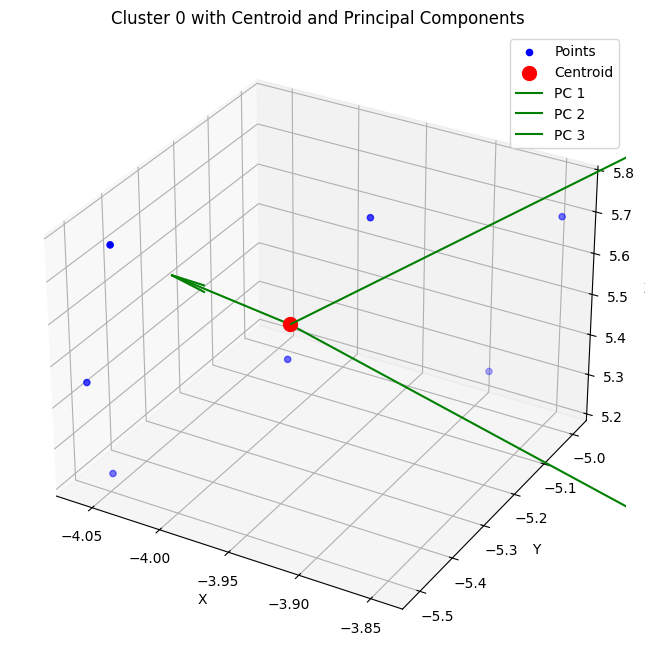

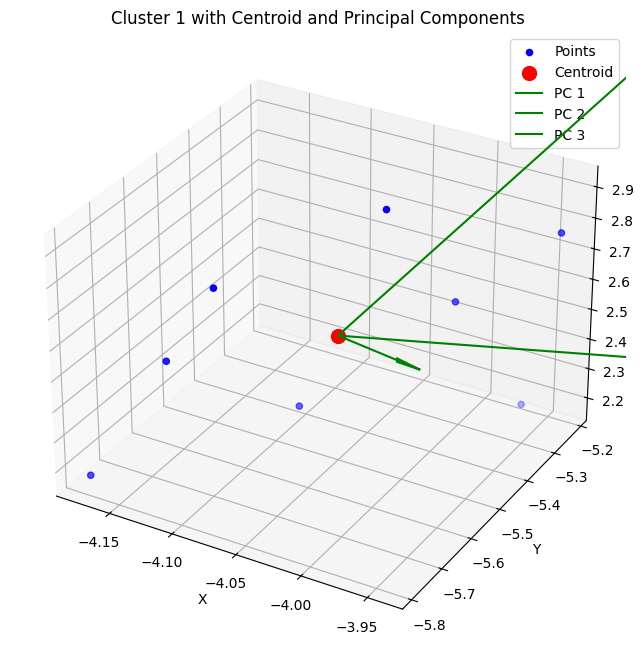

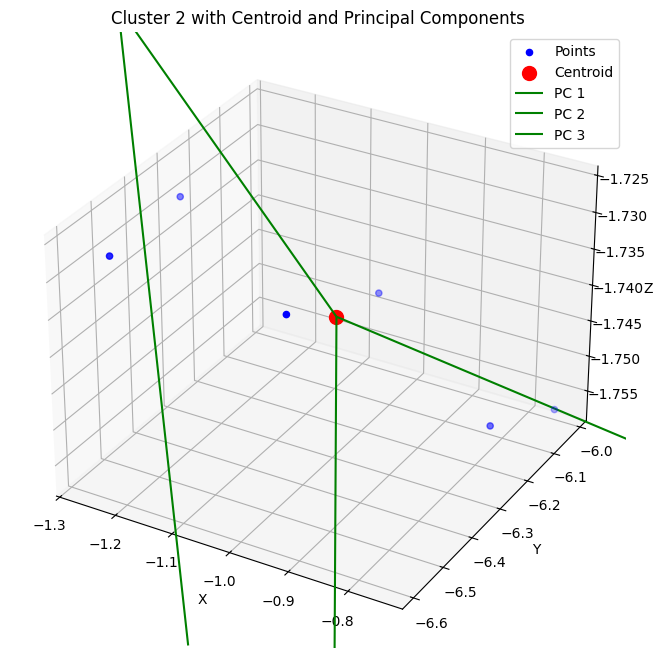

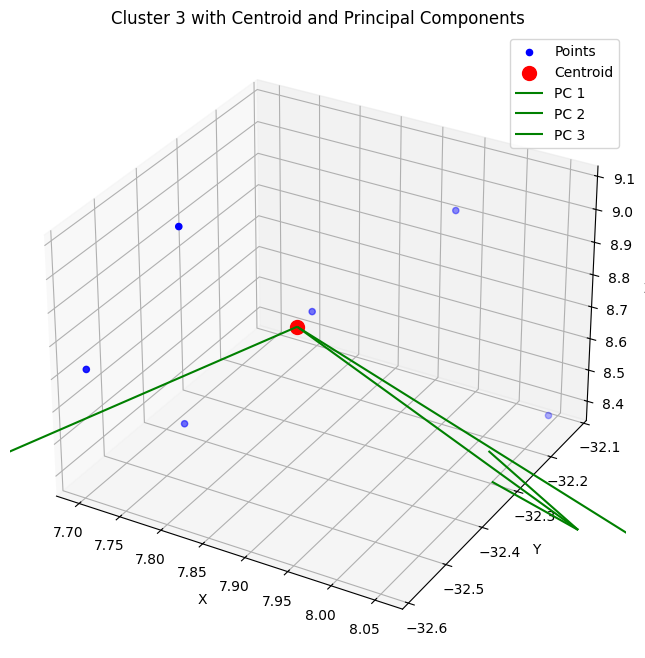

In [88]:


fig = plot_cluster_with_centroid_and_pcs(df, assignment, 0, pcs)
fig.show()

fig = plot_cluster_with_centroid_and_pcs(df, assignment, 1, pcs)
fig.show()

fig = plot_cluster_with_centroid_and_pcs(df, assignment, 2, pcs)
fig.show()

fig = plot_cluster_with_centroid_and_pcs(df, assignment, 3, pcs)
fig.show()

# 3. Support Vector Machine (SVM)
The third part of the assignment is to perform SVM to learn the class label of clusters.


## Define Features and Labels
Each cluster is defined by a set of features, and has a ground-truth label.

> Define the features for the SVM classification. There shape of this matrix should be `[n_clusters, n_features]`. What features should you use to inform the classification model?

In [72]:
# Define labels
labels = dfc['label'].map(lambda x: -1 if "terrain" in x else +1).to_numpy()

# Define features
## TODO START

feature_list = ['x', 'y', 'z', 'intensity', 'r', 'g', 'b']
features = dfc[feature_list].to_numpy()


## TODO END
print(features)
n_features = features.shape[-1]
print(f'{n_features=}')

[[ -3.96857143  -5.29385714   5.527      ... 146.57142857 151.14285714
  156.71428571]
 [ -4.05275     -5.48975      2.52625    ... 134.375      137.5
  143.75      ]
 [ -0.98633333  -6.3135      -1.73866667 ...  41.33333333  44.66666667
   54.        ]
 ...
 [ -4.01985714  -5.41         4.73114286 ... 132.71428571 137.71428571
  145.        ]
 [ 10.6888      -1.112        9.2728     ...  67.          95.2
  122.        ]
 [ 13.26433333 -23.17633333  -1.317      ...  41.          39.66666667
   39.66666667]]
n_features=7


## 4. Evaluate the SVM Optimisation
Optimise the SVM objective to calculate the weight $\mathbf{w}$ and bias $b$ of the linear model.

> Calculate `w` and `b`. Use the algorithms developed in past tutorials.

In [73]:
print(features.shape)  # Should be (n_samples, n_features)
print(labels.shape)

(972, 7)
(972,)


In [85]:
%pip install -q qpsolvers
import qpsolvers
from qpsolvers import solve_qp
solver = qpsolvers.available_solvers[0]

def svm(x, y):
    ## TODO START
    n = len(x) # total number of data points, should be 200
    # x = points # data points of shape [n,f] where f is the number of features
    # y = labels # label values of shape [n]
    y = y.astype(float) # solver requires floats not integers
    l = 1e-5  # lambda

    xy = y[:,None] * x # shape [n, f], gives values of x times by y
    P =  xy @ xy.T # shape [n, n]
    q = -1*np.ones(n) # shape [n]

    n_eq_constr = 3 # number of equality constraints
    n_ineq_constr = 3 # number of inequality constraints

    A = y[None, :] # shape [n_eq_constr, n]
    b = np.zeros(1) # shape [n_eq_constr]

    G = None # shape [n_ineq_constr, n]
    h = None # shape [n_ineq_constr]
    lb = np.zeros(n) # Lower bound shape [n]
    ub = (1 / (2 * n * 1)) * np.ones(n) # Upper bound shape [n]

    c = solve_qp(P, q, G, h, A, b, lb, ub, solver=solver)

    w = c @ xy # Use equation (5) from tutorial 3
    # c_i * y_i * x_i = c . xy

    tol = 1e-5 #Tolerance for finding support vectors, needs to be a small number
    sv = (c > tol) & (c < (1 / (2 * n * l) - tol))

    n_support_vectors =len(sv)

    b_sv = x[sv] @ w - y[sv] # or w @ x[sv].T - y[sv]

    b = b_sv.mean() # Average to achieve a single b value

    ## TODO END
    return w, b

w, b = svm(features, labels)
w, b

/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning:

Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray

/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning:

Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray



(array([ 0.04631281,  0.00630925,  0.0718248 ,  0.01199158, -0.01248987,
        -0.00852069,  0.01058345]),
 -14.578299452918023)

## Evaluation
Evaluate the model and calculate the following metrics:
- Accuracy
- Confusion matrix
- F1 score
- Jaccard (IoU) score
- Plot the ROC curve
- Area under the ROC curve

You can also visualise the labeled point cloud.

> Evaluate the model and calculate the metrics on the test data. You can use the algorithms developed in past tutorials, or `scipy` functions.

In [84]:
## TODO START

#
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, jaccard_score
from sklearn.metrics import roc_curve, roc_auc_score

pred = np.sign(features @ w - b) # see equations (1), (2), and (3) from tutorial 3
pred = pred.astype(int)

def scoresMatrix(labels, pred):
    tp = np.sum( (labels == 1) & (pred == 1) )  # true positive
    fp = np.sum( (labels != 1) & (pred == 1) )  # false positive
    fn = np.sum( (labels == 1) & (pred != 1) )  # false negative
    tn = np.sum( (labels != 1) & (pred != 1) )  # true negative
    return np.array([[tp, fn], [fp, tn]])

def accuracy_score(y_true, y_pred):
    """
    Calculates the accuracy of the predictions
    :param y_true: True labels
    :param y_pred: Predicted labels
    :return: Accuracy as a float between 0 and 1
    """
    cm = scoresMatrix(y_true, y_pred)
    [[tp, fn], [fp, tn]] = cm
    acc = np.sum(np.diag(cm)) / np.sum(cm) # (tp + tn) / (tp + tn + fp + fn)
    return acc

# Compute accuracy
acc = accuracy_score(labels, pred)
confusionmatrix = confusion_matrix(labels, pred)
f1 = f1_score(labels, pred)
jaccard = jaccard_score(labels, pred)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, pred)
auc = roc_auc_score(labels, pred)

print("Accuracy: ", acc)
print("Confusion Matrix:", confusionmatrix, sep='\n')
print("F1 Score: ", f1)
print("Jaccard Score: ", jaccard)
print("AUC: ", auc)



## TODO END

Accuracy:  0.9753086419753086
Confusion Matrix:
[[300   8]
 [ 16 648]]
F1 Score:  0.9818181818181818
Jaccard Score:  0.9642857142857143
AUC:  0.9749647942419027


# Test Set Evaluation
Once the model is trained on the training data set, it should be evaluated on the test set.

- Form point groups from the testing data set with k-means clustering.
- Perform PCA to generate features for each cluster.
- Use the SVM model to predict class labels for the test clusters. Do not retrain the SVM: use `w` and `b` calculated from the training set.
- Evaluate the framework's prediction with the aforementioned metrics.

> The test data set is available in `df_test`. Do not use the `labels` column until the final metric evaluations.

In [ ]:
## TODO START

## TODO END